In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import json
import time
import numpy as np

# Define the directories for train and test datasets
train_dir = '/kaggle/input/dhaka-traffic-classification-4-levels/Dhaka City Traffic Classification Dataset - 4-Level Congestion Analysis/train'
test_dir = '/kaggle/input/dhaka-traffic-classification-4-levels/Dhaka City Traffic Classification Dataset - 4-Level Congestion Analysis/test'

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Load train and test datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Class names
class_names = train_dataset.class_names
print("Class names:", class_names)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Load the EfficientNetB0 model without the top layer
base_model = EfficientNetB0(
    weights='imagenet',  # Pre-trained on ImageNet
    include_top=False,   # Exclude the final dense layer
    input_shape=(128, 128, 3)
)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
model = Sequential([
    Input(shape=(128, 128, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()

# Record start time for training time measurement
start_time = time.time()

EPOCHS = 10

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS
)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Record end time for training time measurement
end_time = time.time()
training_time = end_time - start_time

# Fine-tune the model
base_model.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
fine_tune_epochs = 5
history_fine = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=fine_tune_epochs
)

# Predict on the test dataset
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=-1)

# Get the true labels from the test dataset
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Compute ROC and AUC metrics
true_labels_one_hot = label_binarize(true_labels, classes=range(len(class_names)))

fpr, tpr, roc_auc = {}, {}, {}
for i, class_name in enumerate(class_names):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_names)
macro_auc = auc(all_fpr, mean_tpr)

# Save the results to a JSON file
results = {
    'accuracy': accuracy * 100,
    'training_time': training_time,
    'epochs': EPOCHS + fine_tune_epochs,
    'final_model_history': {
        'accuracy': history_fine.history['accuracy'],
        'loss': history_fine.history['loss'],
        'val_accuracy': history_fine.history['val_accuracy'],
        'val_loss': history_fine.history['val_loss']
    },
    'class_names': class_names,
    'image_size': IMG_SIZE,
    'confusion_matrix': cm.tolist(),
    "roc_curve": {
        "fpr": all_fpr.tolist(),
        "tpr": mean_tpr.tolist(),
        "auc": macro_auc
    }
}

# Save the results in a JSON file
json_file_path = '/kaggle/working/EfficientNetB0_Results_128.json'
with open(json_file_path, 'w') as json_file:
    json.dump(results, json_file)

print(f"Results saved to {json_file_path}")


Found 2390 files belonging to 4 classes.
Found 600 files belonging to 4 classes.
Class names: ['heavy traffic', 'light traffic', 'moderate traffic', 'no traffic']
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 340ms/step - accuracy: 0.5136 - loss: 1.0571 - val_accuracy: 0.5317 - val_loss: 1.1431
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.6858 - loss: 0.7502 - val_accuracy: 0.5483 - val_loss: 1.2216
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.7263 - loss: 0.6598 - val_accuracy: 0.5250 - val_loss: 1.3513
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.7813 - loss: 0.5841 - val_accuracy: 0.5300 - val_loss: 1.3741
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.7879 - loss: 0.5268 - val_accuracy: 0.5483 - val_loss: 1.3772
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.8061 - loss: 0.4905 - val_accuracy: 0.5450 - val_loss: 1.4449
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.8230 - loss: 0.4559 - val_accuracy: 0.5450 - val_loss: 1.5141
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.8501 - loss: 0.4015 - val_accuracy: 0.5583 -

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import json
import time
import numpy as np

# Define the directories for train and test datasets
train_dir = '/kaggle/input/dhaka-traffic-classification-4-levels/Dhaka City Traffic Classification Dataset - 4-Level Congestion Analysis/train'
test_dir = '/kaggle/input/dhaka-traffic-classification-4-levels/Dhaka City Traffic Classification Dataset - 4-Level Congestion Analysis/test'

IMG_SIZE = (256, 256)
BATCH_SIZE = 32

# Load train and test datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Class names
class_names = train_dataset.class_names
print("Class names:", class_names)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Load the EfficientNetB0 model without the top layer
base_model = EfficientNetB0(
    weights='imagenet',  # Pre-trained on ImageNet
    include_top=False,   # Exclude the final dense layer
    input_shape=(256, 256, 3)
)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
model = Sequential([
    Input(shape=(256, 256, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()

# Record start time for training time measurement
start_time = time.time()

EPOCHS = 10

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS
)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Record end time for training time measurement
end_time = time.time()
training_time = end_time - start_time

# Fine-tune the model
base_model.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
fine_tune_epochs = 5
history_fine = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=fine_tune_epochs
)

# Predict on the test dataset
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=-1)

# Get the true labels from the test dataset
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Compute ROC and AUC metrics
true_labels_one_hot = label_binarize(true_labels, classes=range(len(class_names)))

fpr, tpr, roc_auc = {}, {}, {}
for i, class_name in enumerate(class_names):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_names)
macro_auc = auc(all_fpr, mean_tpr)

# Combine all history 
all_history = {
    'accuracy': history.history['accuracy'] + history_fine.history['accuracy'],
    'loss': history.history['loss'] + history_fine.history['loss'],
    'val_accuracy': history.history['val_accuracy'] + history_fine.history['val_accuracy'],
    'val_loss': history.history['val_loss'] + history_fine.history['val_loss']
}

# Prepare results for JSON saving
results = {
    'accuracy': accuracy * 100,
    'training_time': training_time,
    'epochs': EPOCHS + fine_tune_epochs,
    'final_model_history': {
        'accuracy': history_fine.history['accuracy'],
        'loss': history_fine.history['loss'],
        'val_accuracy': history_fine.history['val_accuracy'],
        'val_loss': history_fine.history['val_loss']
    },
    'class_names': class_names,
    'image_size': IMG_SIZE,
    'confusion_matrix': cm.tolist(),
    "roc_curve": {
        "fpr": all_fpr.tolist(),
        "tpr": mean_tpr.tolist(),
        "auc": macro_auc
    }
}

# Save the results in a JSON file
json_file_path = '/kaggle/working/EfficientNetB0_Results_256.json'
with open(json_file_path, 'w') as json_file:
    json.dump(results, json_file)

print(f"Results saved to {json_file_path}")


Found 2390 files belonging to 4 classes.
Found 600 files belonging to 4 classes.
Class names: ['heavy traffic', 'light traffic', 'moderate traffic', 'no traffic']


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 8, 8, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 332ms/step - accuracy: 0.5490 - loss: 1.0120 - val_accuracy: 0.4967 - val_loss: 1.2114
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.6877 - loss: 0.7207 - val_accuracy: 0.5717 - val_loss: 1.2051
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.7170 - loss: 0.6538 - val_accuracy: 0.5583 - val_loss: 1.3086
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.7478 - loss: 0.5906 - val_accuracy: 0.5667 - val_loss: 1.2962
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.7762 - loss: 0.5437 - val_accuracy: 0.5483 - val_loss: 1.3047
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.7882 - loss: 0.5196 - val_accuracy: 0.5733 - val_loss: 1.3081
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.7986 - loss: 0.4947 - val_accuracy: 0.5533 - val_loss: 1.3867
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 0.8212 - loss: 0.4499 - val_accuracy: 0.5517 -

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import json
import time
import numpy as np

# Define the directories for train and test datasets
train_dir = '/kaggle/input/dhaka-traffic-classification-4-levels/Dhaka City Traffic Classification Dataset - 4-Level Congestion Analysis/train'
test_dir = '/kaggle/input/dhaka-traffic-classification-4-levels/Dhaka City Traffic Classification Dataset - 4-Level Congestion Analysis/test'

IMG_SIZE = (512, 512)
BATCH_SIZE = 32

# Load train and test datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=False,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Class names
class_names = train_dataset.class_names
print("Class names:", class_names)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Load the EfficientNetB0 model without the top layer
base_model = EfficientNetB0(
    weights='imagenet',  # Pre-trained on ImageNet
    include_top=False,   # Exclude the final dense layer
    input_shape=(512, 512, 3)
)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
model = Sequential([
    Input(shape=(512, 512, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()

# Record start time for training time measurement
start_time = time.time()

EPOCHS = 10

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS
)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Record end time for training time measurement
end_time = time.time()
training_time = end_time - start_time

# Fine-tune the model
base_model.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
fine_tune_epochs = 5
history_fine = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=fine_tune_epochs
)

# Predict on the test dataset
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=-1)

# Get the true labels from the test dataset
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Compute ROC and AUC metrics
true_labels_one_hot = label_binarize(true_labels, classes=range(len(class_names)))

fpr, tpr, roc_auc = {}, {}, {}
for i, class_name in enumerate(class_names):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(class_names)
macro_auc = auc(all_fpr, mean_tpr)

# Save the results to a JSON file
results = {
    'accuracy': accuracy * 100,
    'training_time': training_time,
    'epochs': EPOCHS + fine_tune_epochs,
    'final_model_history': {
        'accuracy': history_fine.history['accuracy'],
        'loss': history_fine.history['loss'],
        'val_accuracy': history_fine.history['val_accuracy'],
        'val_loss': history_fine.history['val_loss']
    },
    'class_names': class_names,
    'image_size': IMG_SIZE,
    'confusion_matrix': cm.tolist(),
    "roc_curve": {
        "fpr": all_fpr.tolist(),
        "tpr": mean_tpr.tolist(),
        "auc": macro_auc
    }
}

# Save the results in a JSON file
json_file_path = '/kaggle/working/EfficientNetB0_Results_512.json'
with open(json_file_path, 'w') as json_file:
    json.dump(results, json_file)

print(f"Results saved to {json_file_path}")


Found 2390 files belonging to 4 classes.
Found 600 files belonging to 4 classes.
Class names: ['heavy traffic', 'light traffic', 'moderate traffic', 'no traffic']


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 16, 16, 1280)        │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 443ms/step - accuracy: 0.5255 - loss: 1.0586 - val_accuracy: 0.5200 - val_loss: 1.1451
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.6748 - loss: 0.7244 - val_accuracy: 0.5317 - val_loss: 1.2030
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.7125 - loss: 0.6668 - val_accuracy: 0.5617 - val_loss: 1.1535
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.7372 - loss: 0.6302 - val_accuracy: 0.5750 - val_loss: 1.2036
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.7445 - loss: 0.5977 - val_accuracy: 0.5383 - val_loss: 1.2195
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.7634 - loss: 0.5677 - val_accuracy: 0.5433 - val_loss: 1.3475
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.7802 - loss: 0.5281 - val_accuracy: 0.5750 - val_loss: 1.2256
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.7875 - loss: 0.5228 - val_accu

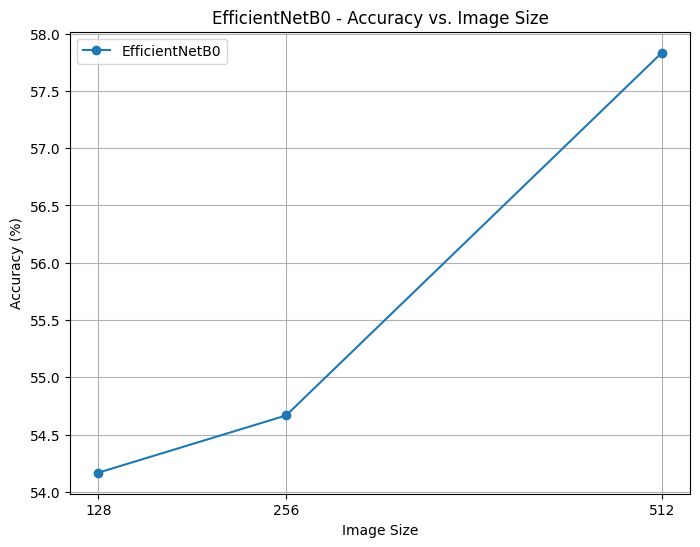

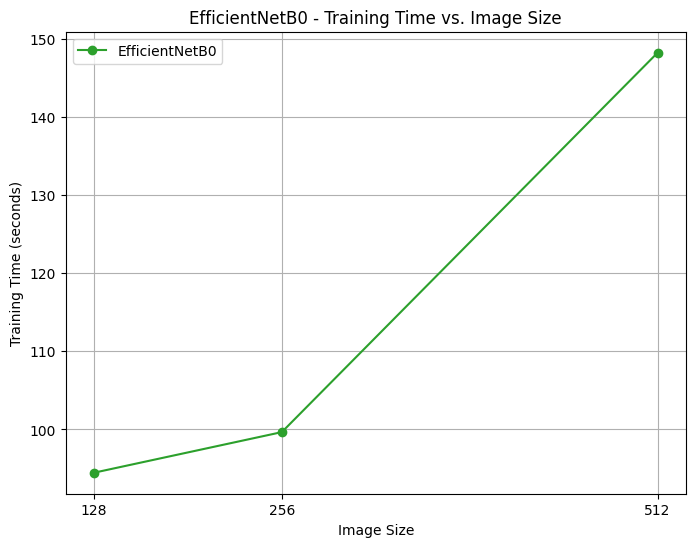

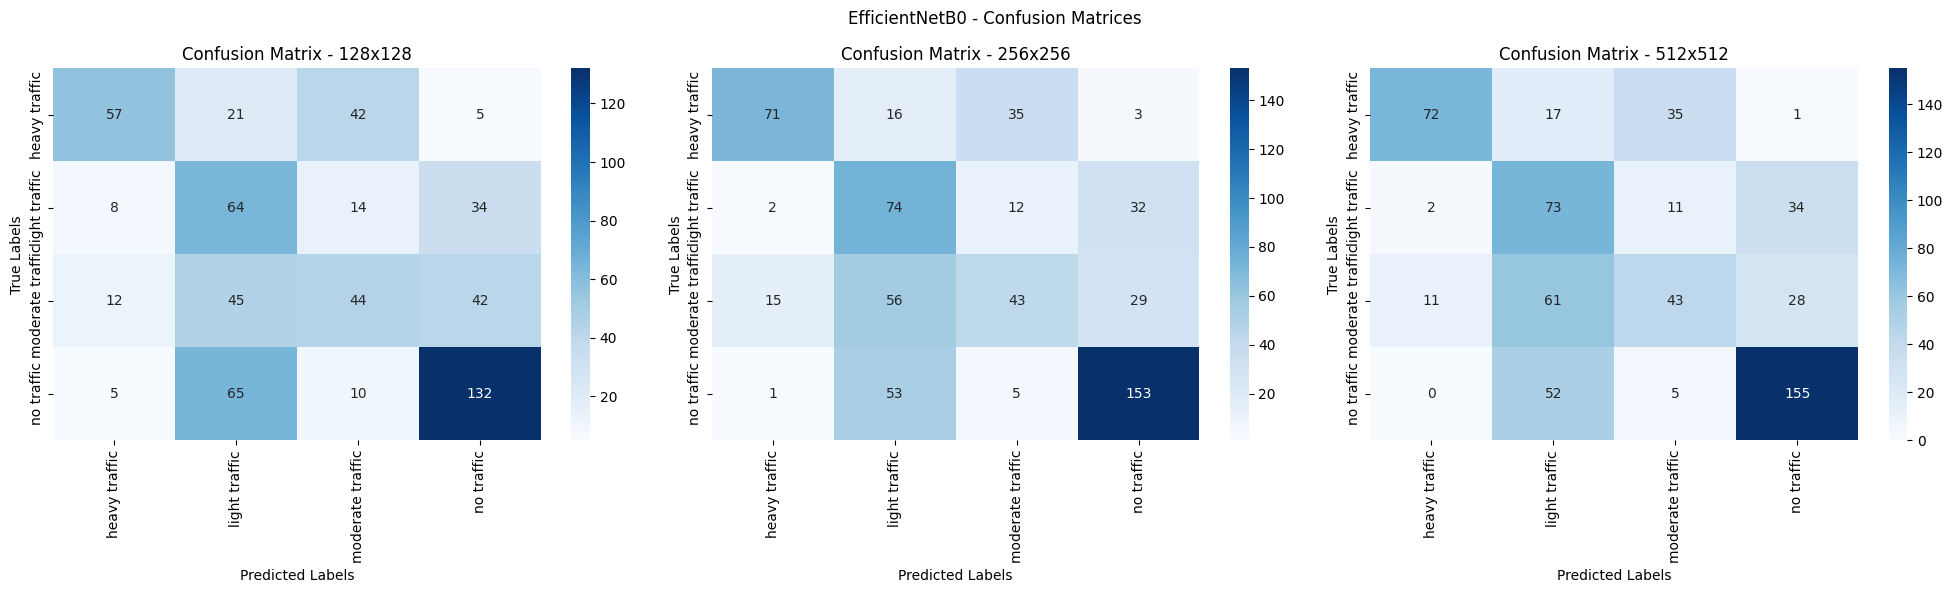

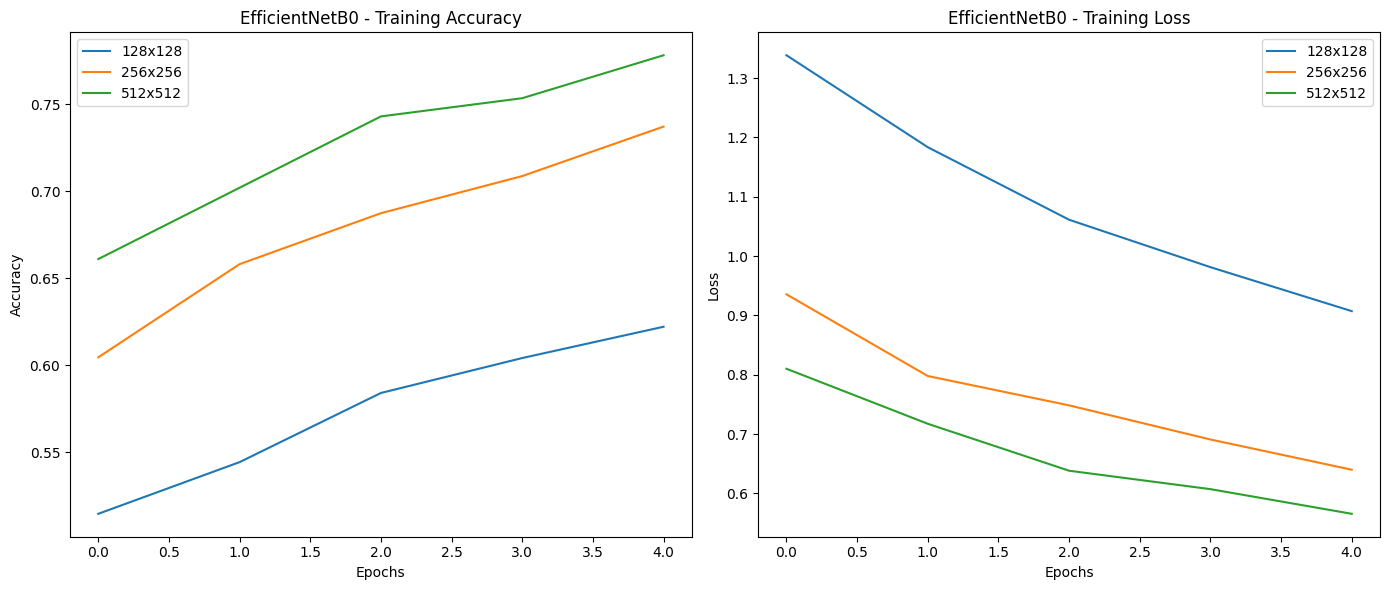

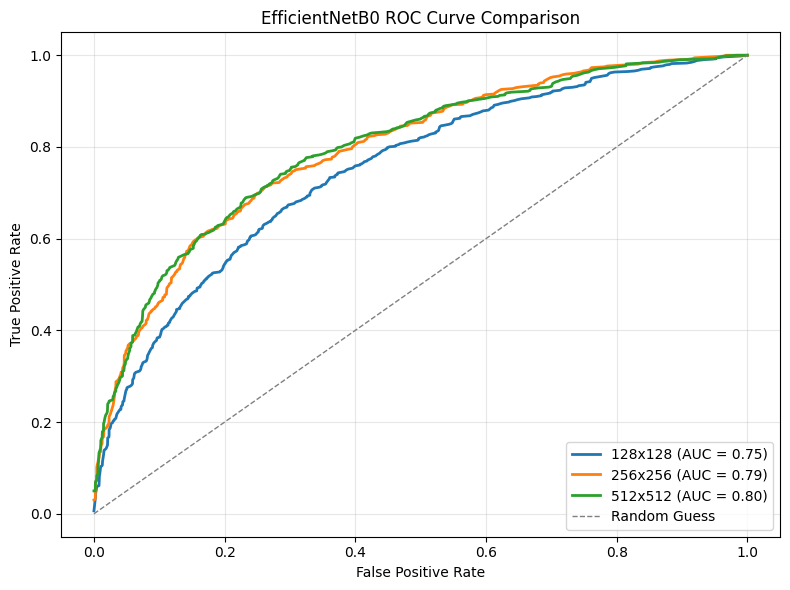

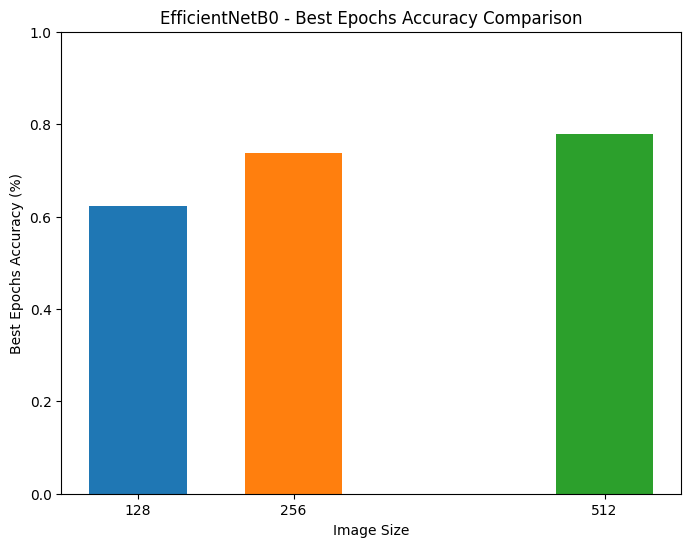

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.ticker as ticker

# Load the three JSON files
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# Paths to the JSON files
json_files = [
    '/kaggle/working/EfficientNetB0_Results_128.json',
    '/kaggle/working/EfficientNetB0_Results_256.json',
    '/kaggle/working/EfficientNetB0_Results_512.json'
]

# Load results for each image size
results_128 = load_json(json_files[0])
results_256 = load_json(json_files[1])
results_512 = load_json(json_files[2])

# Image sizes for x-axis
image_sizes = [128, 256, 512]

# Accuracy and Training Time
accuracy_values = [results_128['accuracy'], results_256['accuracy'], results_512['accuracy']]
training_times = [results_128['training_time'], results_256['training_time'], results_512['training_time']]

# Confusion Matrices
cm_128 = np.array(results_128['confusion_matrix'])
cm_256 = np.array(results_256['confusion_matrix'])
cm_512 = np.array(results_512['confusion_matrix'])

# Final Model Accuracy
final_accuracy = [
    np.max(results_128['final_model_history']['accuracy']),
    np.max(results_256['final_model_history']['accuracy']),
    np.max(results_512['final_model_history']['accuracy'])
]

# Class names
class_names = results_128['class_names']

# Plot 1: Accuracy vs. Image Size
plt.figure(figsize=(8, 6))
plt.plot(image_sizes, accuracy_values, marker='o', color='tab:blue', label='EfficientNetB0')
plt.title('EfficientNetB0 - Accuracy vs. Image Size')
plt.xlabel('Image Size')
plt.ylabel('Accuracy (%)')
plt.xticks(image_sizes)
plt.grid(True)
plt.legend()
plt.savefig('EfficientNetB0_Accuracy_vs_Image_Size.png')
plt.show()

# Plot 2: Training Time vs. Image Size
plt.figure(figsize=(8, 6))
plt.plot(image_sizes, training_times, marker='o', color='tab:green', label='EfficientNetB0')
plt.title('EfficientNetB0 - Training Time vs. Image Size')
plt.xlabel('Image Size')
plt.ylabel('Training Time (seconds)')
plt.xticks(image_sizes)
plt.grid(True)
plt.legend()
plt.savefig('EfficientNetB0_Training_Time_vs_Image_Size.png')
plt.show()

# Plot 3: Confusion Matrices (Side-by-Side Heatmaps)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for ax, cm, size in zip(axes, [cm_128, cm_256, cm_512], image_sizes):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_title(f'Confusion Matrix - {size}x{size}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
plt.suptitle('EfficientNetB0 - Confusion Matrices')
plt.tight_layout()
plt.savefig('EfficientNetB0_Confusion_Matrices.png')
plt.show()

# Plot 4: Learning Curves (Accuracy and Loss vs. Epoch)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
ax[0].plot(results_128['final_model_history']['accuracy'], label='128x128', color='tab:blue')
ax[0].plot(results_256['final_model_history']['accuracy'], label='256x256', color='tab:orange')
ax[0].plot(results_512['final_model_history']['accuracy'], label='512x512', color='tab:green')
ax[0].set_title('EfficientNetB0 - Training Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Loss
ax[1].plot(results_128['final_model_history']['loss'], label='128x128', color='tab:blue')
ax[1].plot(results_256['final_model_history']['loss'], label='256x256', color='tab:orange')
ax[1].plot(results_512['final_model_history']['loss'], label='512x512', color='tab:green')
ax[1].set_title('EfficientNetB0 - Training Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.savefig('EfficientNetB0_Learning_Curves.png')
plt.show()

# Plot 5: ROC Curve
plt.figure(figsize=(8, 6))

# Iterate over image sizes and their results
for size, results, color in zip(
    image_sizes,
    [results_128, results_256, results_512],
    ['tab:blue', 'tab:orange', 'tab:green']
):
    # Safely retrieve 'roc_curve' key
    roc_curve_data = results.get('roc_curve', {})
    fpr = roc_curve_data.get('fpr', [])
    tpr = roc_curve_data.get('tpr', [])
    auc_value = roc_curve_data.get('auc', None)

    if fpr and tpr and auc_value is not None:
        plt.plot(fpr, tpr, color=color, lw=2, label=f'{size}x{size} (AUC = {auc_value:.2f})')
    else:
        print(f"Missing ROC data for image size {size}")

# Add plot details
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('EfficientNetB0 ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('EfficientNetB0_ROC_Curve.png')
plt.show()

# Plot 6: Best Epochs Accuracy Comparison
plt.figure(figsize=(8, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green']
bars = plt.bar(image_sizes, final_accuracy, color=colors, width=80)
plt.title('EfficientNetB0 - Best Epochs Accuracy Comparison')
plt.xlabel('Image Size')
plt.ylabel('Best Epochs Accuracy (%)')
plt.xticks(image_sizes)
plt.gca().xaxis.set_major_locator(ticker.FixedLocator(image_sizes))
plt.ylim(0, 1)
plt.savefig('EfficientNetB0_Best_Epochs_Accuracy_Comparison.png')
plt.show()
